### synthethic failure data

### transfer from one season to another

In [2]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

In [3]:
#always forget to do this for better looking plots
import seaborn
seaborn.set()

import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
#from cvxpy import *
from statsmodels.tsa import stattools
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import random
import copy
import scipy
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#energyplus processing functions
from eplusprocessing import *
from buildsys_funcs import *

In [4]:
def read_file_timestamp(strin):
    out = datetime.datetime.strptime(strin, '%Y-%m-%dT%H:%M:%S')
    return(out)

def file_name_from_timestamp(dtobj):
    out = datetime.datetime.strftime(dtobj, "%Y-%m-%d")
    return(out)

def read_volttron_file(fobj, col=1):
    p = []
    lines = fobj.readlines()
    lines.pop(0)
    for line in lines:
        p.append(float(line.strip().split(",")[col]))
    return(p)

def utc_offset(data_list):
    first = data_list[0:480]
    last = data_list[480:]
    return(last + first)

def to_celsius(fah):
    c = (fah - 32.0)/1.8
    return(c)

def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=0))

def norm_array_custom(arr, minimum, maximum):
    arr_out = (arr - minimum)/(maximum - minimum)
    return(arr_out)

def circularize_normed_data(arr):
    #assume data normalized to 0-1 interval
    x = np.sin(2*np.pi*arr)
    y = np.cos(2*np.pi*arr)
    return(x, y)

filedates = []
for i in range(21,27): #day 27 is missing data
    filedates.append(file_name_from_timestamp(datetime.datetime(year=2018, month=6, day=i)))


In [5]:
moving_average_length = 60 #minutes
bins = 24 #1440/15

### Raw power consumption data minute to minute

In [11]:
datadir = "/home/chase/projects/buildnn/data/PNNL/SEB/"
months = ["March", "April", "May", "June", "July", "August", "September", "October"]

powerdata = []
timedata = []
daydata = []
dtdata = []

for month in months:
    path = datadir + "/" + month + "/" + "ELECTRIC_METER/WholeBuildingDemand/"
    filedates = sorted(os.listdir(path))
    for f in filedates:
        with open(path + f, "r") as d:
            p = []
            t = []
            lines = d.readlines()
            lines.pop(0)
            for line in lines:
                tokens = line.strip().split(",")
                p.append(float(tokens[1]))
                t.append(read_file_timestamp(tokens[0]))
                
            #p = utc_offset(p)
            #t = utc_offset(t)
            
            #moving average according to global moving_average_length time in minutes
            pavg = []
            tavg = []
            wdavg = []
            
            for b in range(bins):
                pavg.append(np.nanmean(p[b*moving_average_length:(b+1)*moving_average_length]))
                try:
                    tavg.append(t[b*moving_average_length].hour*60 + t[b*moving_average_length].minute)
                    wdavg.append(t[b*moving_average_length].weekday())
                    dtdata.append(t[b*moving_average_length])
                except:
                    tavg.append(np.nan)
                    wdavg.append(np.nan)
                    dtdata.append(np.nan)
            powerdata += pavg
            timedata += tavg
            daydata += wdavg

powerdata = np.asarray(powerdata)

/home/chase/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


In [12]:
dtdata

[datetime.datetime(2018, 3, 1, 0, 1, 20),
 datetime.datetime(2018, 3, 1, 1, 1, 20),
 datetime.datetime(2018, 3, 1, 2, 1, 20),
 datetime.datetime(2018, 3, 1, 3, 1, 20),
 datetime.datetime(2018, 3, 1, 4, 1, 20),
 datetime.datetime(2018, 3, 1, 5, 1, 20),
 datetime.datetime(2018, 3, 1, 6, 1, 20),
 datetime.datetime(2018, 3, 1, 7, 1, 20),
 datetime.datetime(2018, 3, 1, 8, 1, 20),
 datetime.datetime(2018, 3, 1, 9, 1, 20),
 datetime.datetime(2018, 3, 1, 10, 1, 20),
 datetime.datetime(2018, 3, 1, 11, 1, 20),
 datetime.datetime(2018, 3, 1, 12, 1, 20),
 datetime.datetime(2018, 3, 1, 13, 1, 20),
 datetime.datetime(2018, 3, 1, 14, 1, 20),
 datetime.datetime(2018, 3, 1, 15, 1, 20),
 datetime.datetime(2018, 3, 1, 16, 1, 20),
 datetime.datetime(2018, 3, 1, 17, 1, 20),
 datetime.datetime(2018, 3, 1, 18, 1, 20),
 datetime.datetime(2018, 3, 1, 19, 1, 20),
 datetime.datetime(2018, 3, 1, 20, 1, 20),
 datetime.datetime(2018, 3, 1, 21, 1, 20),
 datetime.datetime(2018, 3, 1, 22, 1, 20),
 datetime.datetime(20

In [7]:
print(len(powerdata))
print(len(timedata))
print(len(daydata))

5760
5760
5760


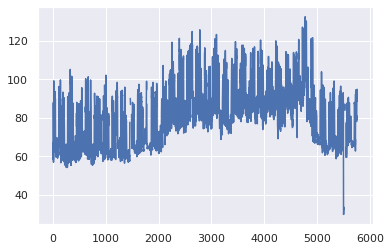

In [8]:
plt.plot(powerdata)
plt.show()

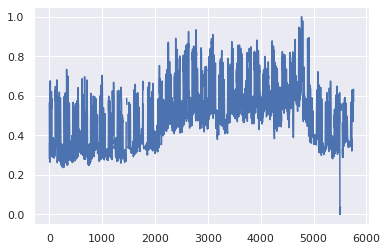

In [9]:
plt.plot(norm_array_custom(powerdata, np.nanmin(powerdata[0:10000]), np.nanmax(powerdata[0:10000])))
plt.show()

### HVAC data

In [387]:
airunits = ["AHU1"]#, "AHU2", "AHU3", "AHU4"]
airvars = ["ExhaustAirFlow", "HotWaterFlowRate", "ExhaustFanPower", 
           "OutdoorAirTemperature", "SupplyFanPower", "MixedAirTemperature", "ReturnAirFlow", 
           "ReturnAirTemperature", "SupplyAirFlow", "SupplyFanPower", "ReturnFanPower", 
           "DischargeAirTemperature", "ChilledWaterValvePosition", "HotWaterValvePosition", 
           "HotWaterCoilTemperature", "HeatingPercent", "DuctStaticPressure", "OutdoorAirFlow",
           "HotWaterSupplyTemperature", "HotWaterReturnTemperature", "HotWaterValveTemperature",
           "HrWheelSpeed", "SupplyFanSpeedPercent"]
vavunits = ["VAV100"]#, "VAV102", "VAV118", "VAV119", "VAV120", "VAV121", "VAV129", "VAV131", "VAV133",
            #"VAV136", "VAV142", "VAV143", "VAV150"]
vavvars = ["ZoneCoolingTemperatureSetPoint", "ZoneTemperature", "ZoneHeatingTemperatureSetPoint", 
           "ZoneTemperatureSetPoint", "ZoneDischargeAirTemperature", "ZoneAirFlow"]

ahudata = {}
vavdata = {}

for a in airunits:
    ahudata[a] = {}
    for m in airvars:
        ahudata[a][m] = []
        
for v in vavunits:
    vavdata[v] = {}
    for m in vavvars:
        vavdata[v][m] = []

for month in months:
    for a in airunits:
        print(month, ": ", a)
        path = datadir + month + "/" + a
        msrmnts = os.listdir(path)
        for m in msrmnts:
            if m in airvars:
                filedates = sorted(os.listdir(path + "/" + m))
                for f in filedates:
                    with open(path + "/" + m + "/" + f, 'r') as d:
                        p = read_volttron_file(d) #utc_offset(read_volttron_file(d))
                        pavg = []
                        for b in range(bins):
                            pavg.append(np.nanmean(p[b*moving_average_length:(b+1)*moving_average_length]))
                        ahudata[a][m] += pavg
                        
            if m in vavunits:
                vav_true_vars = os.listdir(path + "/" + m)
                for v in vav_true_vars:
                    if v in vavvars:
                        filedates = sorted(os.listdir(path + "/" + m + "/" + v))
                        for f in filedates:
                            with open(path + "/" + m + "/" + v + "/" + f, 'r') as d:
                                p = read_volttron_file(d) #utc_offset(read_volttron_file(d))
                                pavg = []
                                for b in range(bins):
                                    pavg.append(np.nanmean(p[b*moving_average_length:(b+1)*moving_average_length]))
                                vavdata[m][v] += pavg

for m in ahudata[a]:
    ahudata[a][m] = np.asarray(ahudata[a][m])

for v in vavdata:
    for mv in vavdata[v]:
        vavdata[v][mv] = np.asarray(vavdata[v][mv])

March :  AHU1


/home/chase/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/home/chase/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice


April :  AHU1
May :  AHU1
June :  AHU1
July :  AHU1
August :  AHU1
September :  AHU1
October :  AHU1


### Data manifest

In [388]:
for a in ahudata:
    for m in ahudata[a]:
        print(a, ", ", m, ", ", len(ahudata[a][m]))

AHU1 ,  ExhaustAirFlow ,  0
AHU1 ,  HotWaterFlowRate ,  23040
AHU1 ,  ExhaustFanPower ,  23040
AHU1 ,  OutdoorAirTemperature ,  23040
AHU1 ,  SupplyFanPower ,  23040
AHU1 ,  MixedAirTemperature ,  23040
AHU1 ,  ReturnAirFlow ,  0
AHU1 ,  ReturnAirTemperature ,  23040
AHU1 ,  SupplyAirFlow ,  0
AHU1 ,  ReturnFanPower ,  0
AHU1 ,  DischargeAirTemperature ,  23040
AHU1 ,  ChilledWaterValvePosition ,  23040
AHU1 ,  HotWaterValvePosition ,  23040
AHU1 ,  HotWaterCoilTemperature ,  0
AHU1 ,  HeatingPercent ,  0
AHU1 ,  DuctStaticPressure ,  23040
AHU1 ,  OutdoorAirFlow ,  23040
AHU1 ,  HotWaterSupplyTemperature ,  23040
AHU1 ,  HotWaterReturnTemperature ,  23040
AHU1 ,  HotWaterValveTemperature ,  23040
AHU1 ,  HrWheelSpeed ,  23040
AHU1 ,  SupplyFanSpeedPercent ,  23040


In [389]:
for a in vavdata:
    for v in vavdata[a]:
        print(a, ", ", v, ", ", len(vavdata[a][v]))

VAV100 ,  ZoneCoolingTemperatureSetPoint ,  23040
VAV100 ,  ZoneTemperature ,  23040
VAV100 ,  ZoneHeatingTemperatureSetPoint ,  23040
VAV100 ,  ZoneTemperatureSetPoint ,  0
VAV100 ,  ZoneDischargeAirTemperature ,  23040
VAV100 ,  ZoneAirFlow ,  23040


In [390]:
### HVAC secondary data

#weather data

In [28]:
#create request file for location: 46.343129, -119.281287
with open("/home/chase/projects/buildnn/data/PNNL/SEB_weather/SEB_weather_req_test.txt", 'w') as d:
    for ut in [dtdata[0]]:
        try:
            unix_time = str(int(ut.timestamp()))
            d.write("https://api.darksky.net/forecast/ce34a9aab021a1f0c4f116b914a88e5d/46.3431,-119.2812," + unix_time + "?exclude=flags\n")
        except:
            pass



with open("/home/chase/projects/buildnn/data/PNNL/SEB_weather/SEB_weather_req.txt", 'w') as d:
    for ut in dtdata:
        try:
            unix_time = str(int(ut.timestamp()))
            d.write("https://api.darksky.net/forecast/ce34a9aab021a1f0c4f116b914a88e5d/46.3431,-119.2812," + unix_time + "?exclude=flags\n")
        except:
            pass



In [23]:
#read weather data: humidity, precipitation at least

nan

In [ ]:
#load SEB weather data

weatherpath = "/home/chase/projects/buildnn/data/PNNL/SEB_weather/data"

humidity = {}
precipIntensity = {}
windSpeed = {}
cloudCover = {}

dates = os.listdir(weatherpath)
for d in sorted(dates):
    with open(weatherpath + "/" + d + "/-119.2812,46.3431.json", 'r') as f:
        strin = f.readline()
        data = json.loads(strin)
        for t in data['hourly']['data']:
            if t['time'] in humidity:
                try:
                    humidity[t['time']].append(t['humidity'])
                    precipIntensity[t['precipIntensity']].append(t['precipIntensity'])
                    windSpeed[t['windSpeed']].append(t['windSpeed'])
                    cloudCover[t['cloudCover']].append(t['cloudCover'])
                except:
                    pass
            else:
                try:
                    humidity[t['time']] = [t['humidity']]
                    precipIntensity[t['precipIntensity']] = [t['precipIntensity']]
                    windSpeed[t['windSpeed']] = [t['windSpeed']]
                    cloudCover[t['cloudCover']] = [t['cloudCover']]
                except:
                    humidity[t['time']] = [0.0]
                    precipIntensity[t['precipIntensity']] = [0.0]
                    windSpeed[t['windSpeed']] = [0.0]
                    cloudCover[t['cloudCover']] = [0.0]
                
for t in humidity:
    humidity[t] = np.mean(humidity[t])
    precipIntensity[t] = np.mean(precipIntensity[t])
    windSpeed[t] = np.mean(windSpeed[t])
    cloudCover[t] = np.mean(cloudCover[t])

In [ ]:
humidity_data = []
for key in sorted(humidity):
    humidity_data.append(humidity[key])

In [ ]:
out_humidity = []
skip = 0
for i in range(len(dtdata)):
    if type(dtdata[i][0]) != datetime.datetime:
        out_humidity.append(0.0)
        skip += 1
    else:
        out_humidity.append(humidity_data[i - skip])

In [431]:
#input variables #including weekday, time of day, and power consumption data at time t

#"ExhaustFanPower","MixedAirTemperature","ReturnAirTemperature","HrWheelSpeed", "HotWaterFlowRate",

airvars_in = ["ExhaustAirFlow",   
           "OutdoorAirTemperature", "SupplyFanPower", "ReturnAirFlow", 
            "SupplyAirFlow", "SupplyFanPower", "ReturnFanPower", 
           "DischargeAirTemperature", "ChilledWaterValvePosition", "HotWaterValvePosition", 
           "HotWaterCoilTemperature", "HeatingPercent", "DuctStaticPressure", "OutdoorAirFlow",
           "HotWaterSupplyTemperature", "HotWaterReturnTemperature", "HotWaterValveTemperature",
           "SupplyFanSpeedPercent"]

vavvars_in = ["ZoneCoolingTemperatureSetPoint", "ZoneTemperature", "ZoneHeatingTemperatureSetPoint", 
           "ZoneTemperatureSetPoint", "ZoneDischargeAirTemperature", "ZoneAirFlow"]

#output variables including building power consumption data at t+steps
airvars_out = ["ReturnAirTemperature", "DischargeAirTemperature","ReturnAirFlow"]

vavvars_out = ["ZoneTemperature", "ZoneDischargeAirTemperature", "ZoneAirFlow"]

In [454]:
#time steps ahead to predict
steps = 4

In [470]:
#array data normalized to first half of year
timedata = np.asarray(timedata)
timedata[np.isnan(timedata)] = 0
daydata = np.asarray(daydata)
daydata[np.isnan(daydata)] = 0

x_t, y_t = circularize_normed_data(norm_array_custom(timedata, np.min(timedata), np.max(timedata)))
x_d, y_d = circularize_normed_data(norm_array_custom(daydata, np.min(daydata), np.max(daydata)))
normed_power = norm_array_custom(powerdata, np.nanmin(powerdata[0:10000]), np.nanmax(powerdata[0:10000]))

 
X_pt_full = np.vstack((normed_power, x_t, y_t, x_d, y_d))

X_pt = X_pt_full[:,:-steps]


X_f = []

for a in airunits:
    for m in airvars_in:
        if len(ahudata[a][m]) > 0:
            if np.isnan(ahudata[a][m]).all():
                pass
            else:
                X_f.append(norm_array_custom(ahudata[a][m], np.nanmin(ahudata[a][m][0:10000]), np.nanmax(ahudata[a][m][0:10000])))

for v in vavunits:
    for m in vavvars_in:
        if a in vavdata and m in vavdata[a]:
            if len(vavdata[a][m]) > 0:
                if np.isnan(vavdata[a][m]).all():
                    pass
                else:
                    X_f.append(norm_array_custom(vavdata[a][m], np.nanmin(vavdata[a][m][0:10000]), np.nanmax(vavdata[a][m][0:10000])))

X_f = np.asarray(X_f)

X = np.vstack((X_pt, X_f[:,:-steps]))
    
    
#clear nans
X[np.isnan(X)] = 0

In [471]:
Y_f = []

for a in airunits:
    for m in airvars_out:
        if len(ahudata[a][m]) > 0:
            if np.isnan(ahudata[a][m]).all():
                pass
            else:
                Y_f.append(norm_array_custom(ahudata[a][m], np.nanmin(ahudata[a][m][0:10000]), np.nanmax(ahudata[a][m][0:10000])))

for v in vavunits:
    for m in vavvars_out:
        if a in vavdata and m in vavdata[a]:
            if len(vavdata[a][m]) > 0:
                if np.isnan(vavdata[a][m]).all():
                    pass
                else:
                    Y_f.append(norm_array_custom(vavdata[a][m], np.nanmin(vavdata[a][m][0:10000]), np.nanmax(vavdata[a][m][0:10000])))

Y_f = np.asarray(Y_f)

Y_pt = X_pt_full[0,1:]
Y = np.vstack((Y_pt, Y_f[:,1:]))

Y_ahead = []
for j in range(Y.shape[1]-steps):
    Y_ahead.append(Y[:,j:j+steps].flatten())
    
Y = np.asarray(Y_ahead).T
#Y = []
#for j in range(X_pt_full[:,1:].shape[1] - steps) #total number of samples
#    curr = []
#    for s in steps:   
#        curr.append(X_pt_full)
#Y = X_pt_full[:,1:]

X = X[:,0:Y.shape[1]]

In [472]:
#clear nans
X[np.isnan(X)] = 0
Y[np.isnan(Y)] = 0

In [473]:
print(X.shape, Y.shape)

(17, 23035) (12, 23035)


/home/chase/applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


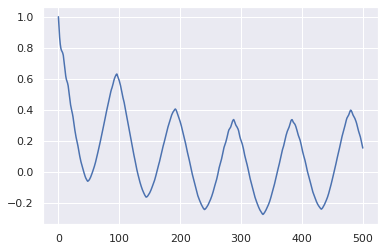

In [474]:
#test ACF/BFC for model order

results = []
for i in range(X.shape[0]):
    try:
        results.append(stattools.acf(X[i,:], nlags=500, missing="drop"))
    except:
        pass
    
plt.plot(np.nanmean(np.asarray(results), axis=0).T)
plt.show()

#model order 96 accounts for entire previous day

In [475]:
#increase model order
order = 1
X_ord = []

for o in range(order,X.shape[1]):
    X_ord.append(X[:,o-order:o].flatten())
    
X_ord = np.asarray(X_ord).T

Y_ord = copy.copy(Y)[:,order:]

In [487]:
#parameter search for kernel degree
l2_losses = []

for i in [1]:#range(8):
    X_poly = polynomial_kernel_mat(X_ord, i)
    X_poly[np.isnan(X_poly)] = 0
    
    reg = None
    reg = linear_model.Ridge(alpha=0.5, fit_intercept=True)
    reg.fit(X_poly[:,0:10000].T, Y_ord[:,0:10000].T)

    A = reg.coef_
    
    l2_losses.append(mean_squared_error(Y_ord[:,10000:].T, A.dot(X_poly[:,10000:]).T, multioutput='uniform_average'))

In [488]:
l2_losses

[0.01659452296093519]

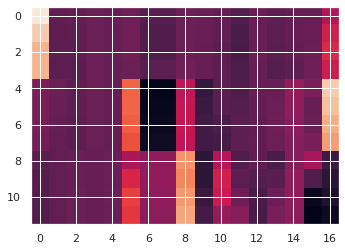

(12, 17)


In [489]:
plt.imshow(A[:,-100:])
plt.show()
print(A.shape)

In [490]:
np.mean(A,axis=0)

array([ 0.23441043, -0.01673281, -0.01592369,  0.00183558,  0.0005594 ,
        0.25291962, -0.07566848, -0.07566848,  0.27246637, -0.08978185,
        0.04039585, -0.04259439, -0.02590695, -0.01732555,  0.05952669,
       -0.03202306,  0.24543079])

In [491]:
#create a perturbed matrix
B = A + np.random.normal(0,1,size=A.shape)

In [492]:
#look at time series of classifier values on training data

lag = 10
likelihoods = []
likelihoods_a = []
likelihoods_b = []

for j in range(Y_ord[:,0:10000-k].shape[1]):
    l_sum = 0.0
    l_sum_a = 0.0
    l_sum_b = 0.0
    for k in range(lag):
        l = likelihood_point(np.expand_dims(X_poly[:,(j+lag)-k], axis=1), np.expand_dims(Y_ord[:,(j+lag)-k], axis=1) + np.random.normal(0,1,size=(A.shape[0],1)), A)
        l_a = likelihood_point(np.expand_dims(X_poly[:,(j+lag)-k], axis=1), A.dot(np.expand_dims(X_poly[:,(j+lag)-k], axis=1)) + np.random.normal(0,1,size=(A.shape[0],1)), A)
        l_b = likelihood_point(np.expand_dims(X_poly[:,(j+lag)-k], axis=1), B.dot(np.expand_dims(X_poly[:,(j+lag)-k], axis=1)) + np.random.normal(0,1,size=(A.shape[0],1)), A)
        l_sum += l
        l_sum_a += l_a
        l_sum_b += l_b
        
    likelihoods.append(l_sum)
    likelihoods_a.append(l_sum_a)
    likelihoods_b.append(l_sum_b)

KeyboardInterrupt: 

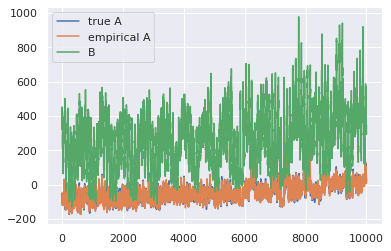

In [484]:
plt.plot(likelihoods, label="true A")
plt.plot(likelihoods_a, label="empirical A")
plt.plot(likelihoods_b, label="B")
plt.legend()
plt.show()

In [ ]:
#look at time series of classifier values on validation data

lag = 1
likelihoods = []
likelihoods_b = []

for j in range(Y[:,10000:].shape[1]):
    l_sum = 0.0
    l_sum_b = 0.0
    for k in range(lag):
        l = likelihood_point(np.expand_dims(X_poly[:,10000+(j-k)], axis=1), np.expand_dims(Y_ord[:,10000+(j-k)], axis=1) + np.random.normal(0,1,size=(A.shape[0],1)), A)
        l_b = likelihood_point(np.expand_dims(X_poly[:,10000+(j-k)], axis=1), B.dot(np.expand_dims(X_poly[:,10000+(j-k)], axis=1)) + np.random.normal(0,1,size=(A.shape[0],1)), A)
        l_sum += l
        l_sum_b += l_b
        
    likelihoods.append(l_sum)
    likelihoods_b.append(l_sum_b)

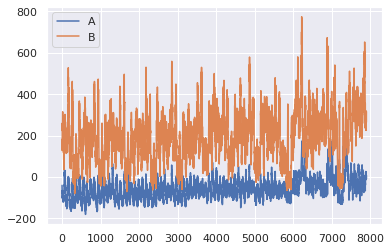

In [493]:
plt.plot(likelihoods, label="A")
plt.plot(likelihoods_b, label="B")
plt.legend()
plt.show()